In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
from transformers import BertModel, BertTokenizer
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 仅文本模型
class TextOnlyModel(nn.Module):
    def __init__(self, text_model_name='bert-base-uncased', num_classes=3):
        super(TextOnlyModel, self).__init__()
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, text_input):
        text_features = self.text_model(**text_input).last_hidden_state[:, 0, :]
        text_features = self.text_fc(text_features)
        logits = self.classifier(text_features)
        return logits


# 仅图像模型
class ImageOnlyModel(nn.Module):
    def __init__(self, img_model_name='resnet50', num_classes=3):
        super(ImageOnlyModel, self).__init__()
        self.img_model = resnet50(pretrained=True)
        self.img_model.fc = nn.Linear(self.img_model.fc.in_features, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, img_input):
        img_features = self.img_model(img_input)
        logits = self.classifier(img_features)
        return logits

# 多模态融合模型
class MultimodalModel(nn.Module):
    # 复杂模型
    '''
    def __init__(self, text_model_name='bert-base-uncased', img_model_name='resnet50', num_classes=3):
        super(MultimodalModel, self).__init__()
        # 文本特征提取
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 256)  # BERT 输出维度为 768
        # 图像特征提取
        self.img_model = resnet50(pretrained=True)
        self.img_model.fc = nn.Linear(self.img_model.fc.in_features, 256)  # ResNet 输出维度为 256
        # 多模态融合
        self.fusion_fc = nn.Linear(256 + 256, 128)  # 拼接后的特征维度
        # Dropout 层
        self.dropout = nn.Dropout(0.5)  # 添加 Dropout
        # 分类器
        self.classifier = nn.Linear(128, num_classes)
    '''
    
    # 简单模型
    def __init__(self, text_model_name='bert-base-uncased', img_model_name='resnet50', num_classes=3):
        super(MultimodalModel, self).__init__()
        # 文本特征提取
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 128)  # 减少维度
        # 图像特征提取
        self.img_model = resnet50(pretrained=True)
        self.img_model.fc = nn.Linear(self.img_model.fc.in_features, 128)  # 减少维度
        # 多模态融合
        self.fusion_fc = nn.Linear(128 + 128, 64)  # 减少维度
        # Dropout 层
        self.dropout = nn.Dropout(0.5)
        # 分类器
        self.classifier = nn.Linear(64, num_classes)

    

    def forward(self, text_input, img_input):
        # 文本特征
        text_features = self.text_model(**text_input).last_hidden_state[:, 0, :]  # 取 [CLS] 向量
        text_features = self.text_fc(text_features)
        # 图像特征
        img_features = self.img_model(img_input)
        # 特征融合
        fused_features = torch.cat((text_features, img_features), dim=1)
        fused_features = self.fusion_fc(fused_features)
        # Dropout
        fused_features = self.dropout(fused_features) 
        # 分类
        logits = self.classifier(fused_features)
        return logits


# 自定义数据集
class MultimodalDataset:
    def __init__(self, texts, images, labels, tokenizer, transform):
        self.texts = texts
        self.images = images
        self.labels = labels
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]
        # 文本编码
        text_input = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)
        # 图像预处理
        image = self.transform(image)
        return text_input, image, label




In [2]:
# 训练和验证函数
def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # 训练
        model.train()
        total_train_loss = 0
        for text_input, image, label in train_dataloader:
            text_input = {key: value.squeeze(1).to(device) for key, value in text_input.items()}
            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            if isinstance(model, TextOnlyModel):
                logits = model(text_input)
            elif isinstance(model, ImageOnlyModel):
                logits = model(image)
            else:
                logits = model(text_input, image)
            loss = criterion(logits, label)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # 验证
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for text_input, image, label in val_dataloader:
                text_input = {key: value.squeeze(1).to(device) for key, value in text_input.items()}
                image = image.to(device)
                label = label.to(device)

                if isinstance(model, TextOnlyModel):
                    logits = model(text_input)
                elif isinstance(model, ImageOnlyModel):
                    logits = model(image)
                else:
                    logits = model(text_input, image)
                loss = criterion(logits, label)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        # 更新学习率
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print("-" * 50)

    return train_losses, val_losses

#  保存损失到文件
def save_loss_to_file(train_losses, val_losses, filename):
    with open(filename, 'w') as f:
        f.write("Epoch,Train Loss,Validation Loss\n")
        for epoch, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses), start=1):
            f.write(f"{epoch},{train_loss},{val_loss}\n")
# 从文件读取损失
def read_loss_from_file(filename):
    train_losses = []
    val_losses = []
    with open(filename, 'r') as f:
        next(f)  # 跳过表头
        for line in f:
            epoch, train_loss, val_loss = line.strip().split(',')
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
    return train_losses, val_losses


In [3]:
# 定义需要尝试的编码方式列表
ENCODINGS_TO_TRY = [
    'utf-8', 'ascii', 'gbk', 'big5', 'iso-8859-1', 'iso-8859-9',
    'windows-1251', 'windows-1252', 'windows-1253', 'windows-1254',
    'ibm866', 'koi8-r', 'tis-620', 'euc-jp', 'macroman'
]

# 加载 train.txt 文件
train_df = pd.read_csv('train.txt')

# 初始化 lists
texts = []
images = []
labels = []

# 遍历 train.txt 中的每一行
for guid, tag in train_df.values:
    # 加载文本
    text_path = os.path.join('data', f'{guid}.txt')
    
    # 检查文件是否存在
    if not os.path.exists(text_path):
        print(f"File not found: {text_path}")
        continue
    
    # 尝试多种编码方式读取文件
    text = None
    for encoding in ENCODINGS_TO_TRY:
        try:
            with open(text_path, 'r', encoding=encoding) as f:
                text = f.read().strip()
            break  
        except UnicodeDecodeError:
            continue
    
    # 如果所有编码方式都失败，记录错误并跳过该文件
    if text is None:
        print(f"Failed to read file {text_path} with all tried encodings.")
        continue
    
    texts.append(text)
    
    # 加载图像路径
    image_path = os.path.join('data', f'{guid}.jpg')
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue
    images.append(image_path)
    
    # 加载标签
    labels.append(tag)

# 标签编码
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # 转换为 0, 1, 2

# 划分训练集和验证集
train_texts, val_texts, train_images, val_images, train_labels, val_labels = train_test_split(
    texts, images, labels, test_size=0.2, random_state=42
)

# 数据预处理
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(10),  # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 超参数选择
batch_size = 128
learning_rate = 8e-6
num_epochs = 6

# 构建 DataLoader
train_dataset = MultimodalDataset(train_texts, train_images, train_labels, tokenizer, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultimodalDataset(val_texts, val_images, val_labels, tokenizer, transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# 初始化模型
text_model = TextOnlyModel().to(device)
image_model = ImageOnlyModel().to(device)
multimodal_model = MultimodalModel().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_text = torch.optim.Adam(text_model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_image = torch.optim.Adam(image_model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer_multimodal = torch.optim.Adam(multimodal_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# 定义学习率调度器
scheduler_text = ReduceLROnPlateau(optimizer_text, mode='min', factor=0.1, patience=2, verbose=True)
scheduler_image = ReduceLROnPlateau(optimizer_image, mode='min', factor=0.1, patience=2, verbose=True)
scheduler_multimodal = ReduceLROnPlateau(optimizer_multimodal, mode='min', factor=0.1, patience=2, verbose=True)

# 训练并记录损失
text_train_losses, text_val_losses = train_and_validate(text_model, train_dataloader, val_dataloader, criterion, optimizer_text, scheduler_text, device, num_epochs)
save_loss_to_file(text_train_losses, text_val_losses, 'text_losses.txt')

image_train_losses, image_val_losses = train_and_validate(image_model, train_dataloader, val_dataloader, criterion, optimizer_image, scheduler_image, device, num_epochs)
save_loss_to_file(image_train_losses, image_val_losses, 'image_losses.txt')

multimodal_train_losses, multimodal_val_losses = train_and_validate(multimodal_model, train_dataloader, val_dataloader, criterion, optimizer_multimodal, scheduler_multimodal, device, num_epochs)
save_loss_to_file(multimodal_train_losses, multimodal_val_losses, 'multimodal_losses.txt')

2
3
4
5
Train set: 3200 samples
Validation set: 800 samples
cuda


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/6
Train Loss: 0.9599, Validation Loss: 0.8897
--------------------------------------------------
Epoch 2/6
Train Loss: 0.8767, Validation Loss: 0.8541
--------------------------------------------------
Epoch 3/6
Train Loss: 0.8249, Validation Loss: 0.7859
--------------------------------------------------
Epoch 4/6
Train Loss: 0.7459, Validation Loss: 0.7046
--------------------------------------------------
Epoch 5/6
Train Loss: 0.6521, Validation Loss: 0.6674
--------------------------------------------------
Epoch 6/6
Train Loss: 0.5795, Validation Loss: 0.6624
--------------------------------------------------


"\n# 读取损失数据\ntext_train_losses, text_val_losses = read_loss_from_file('text_losses.txt')\nimage_train_losses, image_val_losses = read_loss_from_file('image_losses.txt')\nmultimodal_train_losses, multimodal_val_losses = read_loss_from_file('multimodal_losses.txt')\n\n# 绘制损失曲线\nplt.figure(figsize=(12, 8))\nplt.plot(range(1, num_epochs + 1), text_train_losses, label='Text Train Loss', marker='o')\nplt.plot(range(1, num_epochs + 1), text_val_losses, label='Text Validation Loss', marker='o')\nplt.plot(range(1, num_epochs + 1), image_train_losses, label='Image Train Loss', marker='o')\nplt.plot(range(1, num_epochs + 1), image_val_losses, label='Image Validation Loss', marker='o')\nplt.plot(range(1, num_epochs + 1), multimodal_train_losses, label='Multimodal Train Loss', marker='o')\nplt.plot(range(1, num_epochs + 1), multimodal_val_losses, label='Multimodal Validation Loss', marker='o')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss for Text, Image, and Mul

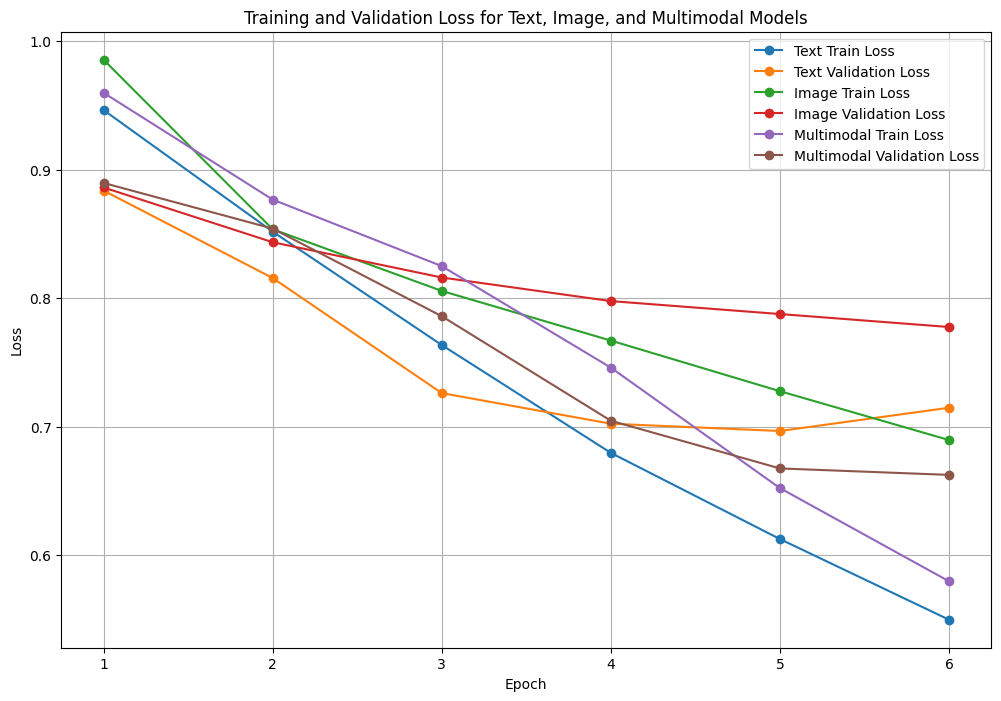

In [5]:
# 读取损失数据
text_train_losses, text_val_losses = read_loss_from_file('text_losses.txt')
image_train_losses, image_val_losses = read_loss_from_file('image_losses.txt')
multimodal_train_losses, multimodal_val_losses = read_loss_from_file('multimodal_losses.txt')

# 绘制损失曲线
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), text_train_losses, label='Text Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), text_val_losses, label='Text Validation Loss', marker='o')
plt.plot(range(1, num_epochs + 1), image_train_losses, label='Image Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), image_val_losses, label='Image Validation Loss', marker='o')
plt.plot(range(1, num_epochs + 1), multimodal_train_losses, label='Multimodal Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), multimodal_val_losses, label='Multimodal Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Text, Image, and Multimodal Models')
plt.legend()
plt.grid(True)

plt.savefig('total_loss_curve.png', dpi=300, bbox_inches='tight')  # 保存为图片
plt.show()  